In [1]:
import os
import itertools
from collections import Counter
import json

from tqdm import tqdm

import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

from sklearn.metrics import make_scorer, mean_squared_error
from scipy.stats import pearsonr
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
from utils import mixup, write_pickled_object, cohen_d
from utils import get_stats as get_stats_best
from utils import FeatureSelector, MeanCenterer

In [2]:
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'
random_state = 42

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

In [3]:
res = pd.read_csv(os.path.join(data_path, 'interim', 
                               'pipeline_model_selection_transcriptomics_individual.csv'), index_col = 0)
model_types = ['Ridge', 'ElasticNet', 'Lasso', 'PLS', 'SVR_linear',
               'SVR_poly', 'SVR_rbf', 'KNN', 'RFR']
res.model_type = pd.Categorical(res.model_type, categories = model_types, ordered = True)

Let's take a look at the results from the model selection:

In [252]:
# sort by mean correlation
ordered_corr = res.groupby('model_type')[['test_corr', 'test_mse']].mean().sort_values(by = 'test_corr', ascending=False)
corr_order = ordered_corr.index.tolist()
ordered_corr




/tmp/ipykernel_2786948/3614711499.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ordered_corr = res.groupby('model_type')[['test_corr', 'test_mse']].mean().sort_values(by = 'test_corr', ascending=False)


,test_corr,test_mse
model_type,,
SVR_rbf,0.512561,1.903291
SVR_poly,0.509745,1.919126
SVR_linear,0.497427,1.964935
Ridge,0.483302,2.066285
Lasso,0.478047,2.021607
ElasticNet,0.461298,2.059783
RFR,0.451958,2.110077
PLS,0.423955,2.284034
KNN,0.404975,2.164122


In [253]:
# sort by median correlation
res.groupby('model_type')[['test_corr', 'test_mse']].median().sort_values(by = 'test_corr', ascending=False)

/tmp/ipykernel_2786948/2570664844.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res.groupby('model_type')[['test_corr', 'test_mse']].median().sort_values(by = 'test_corr', ascending=False)


,test_corr,test_mse
model_type,,
SVR_rbf,0.525242,1.787037
SVR_poly,0.514944,1.850665
SVR_linear,0.508349,1.839563
Ridge,0.497687,1.996531
ElasticNet,0.474072,1.889013
RFR,0.464830,1.937285
Lasso,0.464739,1.897369
PLS,0.462130,2.218199
KNN,0.370612,2.058559


In [254]:
# sort by correlation variance
res.groupby('model_type').test_corr.var().sort_values(ascending = True)

/tmp/ipykernel_2786948/1169242599.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res.groupby('model_type').test_corr.var().sort_values(ascending = True)


model_type
Ridge         0.013325
SVR_poly      0.014787
SVR_rbf       0.014963
SVR_linear    0.015798
RFR           0.017387
Lasso         0.017997
ElasticNet    0.019632
KNN           0.024169
PLS           0.030738
Name: test_corr, dtype: float64

In [255]:
# sort by mean MSE
ordered_mse = res.groupby('model_type')[['test_corr', 'test_mse']].mean().sort_values(by = 'test_mse', ascending=True)
mse_order = ordered_mse.index.tolist()
ordered_mse

/tmp/ipykernel_2786948/2640724910.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ordered_mse = res.groupby('model_type')[['test_corr', 'test_mse']].mean().sort_values(by = 'test_mse', ascending=True)


,test_corr,test_mse
model_type,,
SVR_rbf,0.512561,1.903291
SVR_poly,0.509745,1.919126
SVR_linear,0.497427,1.964935
Lasso,0.478047,2.021607
ElasticNet,0.461298,2.059783
Ridge,0.483302,2.066285
RFR,0.451958,2.110077
KNN,0.404975,2.164122
PLS,0.423955,2.284034


In [256]:
# sort by median MSE
res.groupby('model_type')[['test_corr', 'test_mse']].median().sort_values(by = 'test_mse', ascending=True)

/tmp/ipykernel_2786948/1731851835.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res.groupby('model_type')[['test_corr', 'test_mse']].median().sort_values(by = 'test_mse', ascending=True)


,test_corr,test_mse
model_type,,
SVR_rbf,0.525242,1.787037
SVR_linear,0.508349,1.839563
SVR_poly,0.514944,1.850665
ElasticNet,0.474072,1.889013
Lasso,0.464739,1.897369
RFR,0.464830,1.937285
Ridge,0.497687,1.996531
KNN,0.370612,2.058559
PLS,0.462130,2.218199


In [257]:
# sort by mse variance
res.groupby('model_type').test_mse.var().sort_values(ascending = True)

/tmp/ipykernel_2786948/3230113901.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res.groupby('model_type').test_mse.var().sort_values(ascending = True)


model_type
SVR_rbf       0.125238
Ridge         0.141821
RFR           0.148886
SVR_poly      0.156736
Lasso         0.158171
SVR_linear    0.180551
KNN           0.192924
ElasticNet    0.216207
PLS           0.317277
Name: test_mse, dtype: float64

Let's compare each models performance with identified best hyperparameters for a specific fold:

In [258]:
res_stats = pd.DataFrame(columns = ['comparison', 'pval_corr', 'cohen_d_corr', 
                                   'pval_mse', 'cohen_d_mse'])
mod_combs = itertools.combinations((res.model_type.unique()), 2)

for mc in mod_combs:
    a = res[res.model_type == mc[0]]
    b = res[res.model_type == mc[1]]
    
    pval_corr = stats.mannwhitneyu(a.test_corr,b.test_corr).pvalue
    cd_corr = cohen_d(a.test_corr,b.test_corr)
    
    pval_mse = stats.mannwhitneyu(a.test_mse,b.test_mse).pvalue
    cd_mse = cohen_d(a.test_mse,b.test_mse)
    
    res_stats.loc[res_stats.shape[0], :] = [mc, pval_corr, cd_corr, pval_mse, cd_mse]
    
_, fdr_corr, _, _ = multipletests(res_stats.pval_corr.values, method='fdr_bh')
_, fdr_mse, _, _ = multipletests(res_stats.pval_mse.values, method='fdr_bh')
res_stats['fdr_corr'] = fdr_corr
res_stats['fdr_mse'] = fdr_mse
res_stats

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse
0,"(SVR_linear, PLS)",0.307489,0.481661,0.212294,-0.639589,0.893348,0.856126
1,"(SVR_linear, SVR_poly)",0.850107,-0.09961,0.791337,0.111549,0.927389,0.863276
2,"(SVR_linear, SVR_rbf)",0.73373,-0.122026,0.791337,0.15765,0.927389,0.863276
3,"(SVR_linear, RFR)",0.344704,0.352994,0.212294,-0.357621,0.893348,0.856126
4,"(SVR_linear, Ridge)",0.677585,0.117058,0.472676,-0.252442,0.927389,0.856126
5,"(SVR_linear, Lasso)",0.791337,0.149087,0.520523,-0.13771,0.927389,0.856126
6,"(SVR_linear, ElasticNet)",0.57075,0.271448,0.623176,-0.212952,0.893348,0.862859
7,"(SVR_linear, KNN)",0.212294,0.654007,0.307489,-0.460941,0.893348,0.856126
8,"(PLS, SVR_poly)",0.185877,-0.56863,0.10411,0.749555,0.893348,0.856126
9,"(PLS, SVR_rbf)",0.241322,-0.586155,0.121225,0.809437,0.893348,0.856126


In [259]:
res_stats[res_stats.fdr_corr <= 0.1]

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse


In [260]:
res_stats[res_stats.fdr_mse <= 0.1]

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse


There are no significant differences in model performance by either Pearson correlation or MSE.

/tmp/ipykernel_2786948/1467105035.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = ax[i],
/tmp/ipykernel_2786948/1467105035.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(xlabels,
/tmp/ipykernel_2786948/1467105035.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = ax[i],
/tmp/ipykernel_2786948/1467105035.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].s

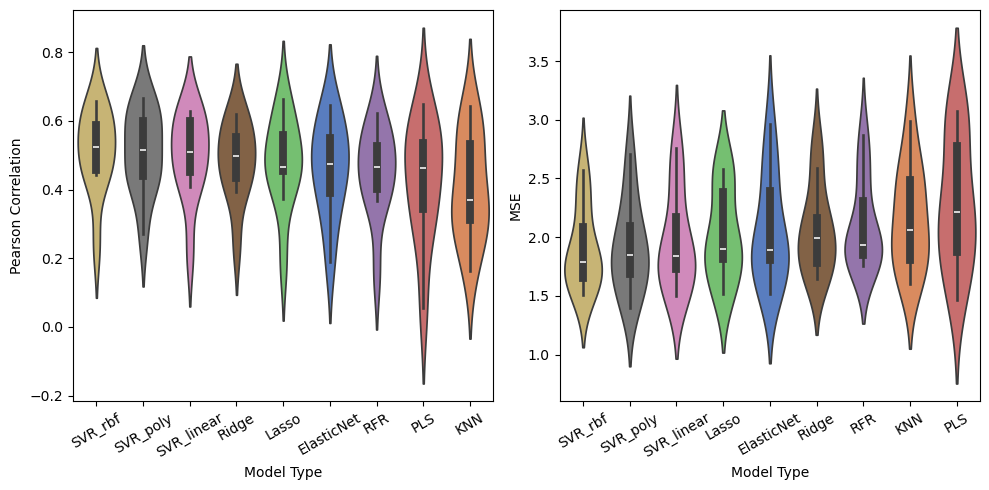

In [261]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,5))

metric_types = ['corr', 'mse']
mmap = dict(zip(metric_types, ['Pearson Correlation', 'MSE']))
order_map = dict(zip(metric_types, [corr_order, mse_order]))

palette = dict(zip(sorted(res.model_type.unique()), sns.color_palette("muted")))

for i, metric_type in enumerate(metric_types):
    # sort by mean of metric
    res.model_type = pd.Categorical(res.model_type, categories = order_map[metric_type], 
                               ordered = True)
    
    
    sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = ax[i], 
                  palette = palette)#,
#                    fill = False, inner = None)
    
#     sns.boxplot(data=res, x = 'model_type', y = 'test_' + metric_type, 
#                 width=0.1, 
#                 color="black", showcaps=False, boxprops={'facecolor':'none'}, 
#                 whiskerprops={'linewidth':0.5}, ax = ax[i])
#     sns.stripplot(data=res, x = 'model_type', y = 'test_' + metric_type, 
#                   alpha=0.5, jitter=True, dodge=True, ax = ax[i], color = 'black')
    
    ax[i].set_xlabel('Model Type')
    ax[i].set_ylabel(mmap[metric_type])
    
    xlabels = [x._text for x in ax[i].get_xticklabels()]
    x_pos = dict(zip(xlabels, ax[i].get_xticks()))
    y, h = ax[i].get_ylim()[1], 0.05
    
    ax[i].set_xticklabels(xlabels, 
                          rotation=30, 
                         ha = 'center')
    
    sig_counter = 0
    for j, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2
        
        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr_' + metric_type].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d_' + metric_type].values[0]
        
        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"
        
        if significance != 'N.S.':
            y_pos = y+(sig_counter*0.15)
            ax[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                       [y_pos, y_pos+h, y_pos+h, y_pos], 
                       lw=1.5, c='black')
            y_pos*=1.01
            ax[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1

#     ax[i].grid(axis='y', linestyle='--', alpha=0.7)
    
fig.tight_layout()


For each metric (panels), violin plots are ordered by the best performing mean value across folds. Each fold has the best model selected using optuna hyperparameter tuning. We observe the following: 
- there are no significant differences in any of the model performance for both correlation and MSE
- relative model performance is consistent between correlation and MSE, with SVMs performing best
- the worse performing models tend to have higher variance across folds

Thus, for this dataset, non-linear models do not outperform linear models.

# Consensus model

In [4]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0).values
y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential.csv'), index_col = 0)['mean'].values.ravel()


Given that SVMs perform best and there are no significant differences, we proceed with the linear SVM as it is more interpretable. We generate a consensus model based on the hyperparameters selected across folds. We assess how that consensus model performs across a 10-fold split that is different than the one run during Notebook 02.

In [5]:
model_type = 'SVR_linear'
print(model_type)

res_model = res[res.model_type == model_type]

C_best = []
epsilon_best = []
for bp in res_model.best_params:
    print(bp)
    print('------------------------------------------------------')
    C_best.append(float(bp.split(', ')[1].split(': ')[1]))
    epsilon_best.append(float(bp.split(', ')[2].split(': ')[1][:-1]))

SVR_linear
{'FeatureSelector__n_features': 19138, 'SVR_linear__C': 0.0034255568027342434, 'SVR_linear__epsilon': 0.9205851982875526}
------------------------------------------------------
{'FeatureSelector__n_features': 19138, 'SVR_linear__C': 0.13581901109084174, 'SVR_linear__epsilon': 0.7444774082387232}
------------------------------------------------------
{'FeatureSelector__n_features': 19138, 'SVR_linear__C': 0.00010924293011941776, 'SVR_linear__epsilon': 0.2723068469923791}
------------------------------------------------------
{'FeatureSelector__n_features': 19138, 'SVR_linear__C': 0.00015468542611289592, 'SVR_linear__epsilon': 0.8125624173609625}
------------------------------------------------------
{'FeatureSelector__n_features': 19138, 'SVR_linear__C': 0.22697372851801703, 'SVR_linear__epsilon': 0.9795821714495729}
------------------------------------------------------
{'FeatureSelector__n_features': 19138, 'SVR_linear__C': 0.025729271311854904, 'SVR_linear__epsilon': 0.904

We see that consistently, all features were selected. For the C and epsilon hyperparameters, we take the mean value across folds.

In [6]:
best_steps = [
    ("feature_reduction", FeatureSelector(n_features = 19138)),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='linear',
    C=np.mean(C_best),
    epsilon=np.mean(epsilon_best)
#     random_state=random_state,
#     n_jobs=n_cores
)))
best_pipeline = Pipeline(best_steps)
write_pickled_object(best_pipeline, 
                    os.path.join(data_path, 'processed', 'best_model.pickle'))
best_pipeline

Pipeline(steps=[('feature_reduction', FeatureSelector(n_features=19138)),
                ('mean_centering', MeanCenterer()),
                ('model',
                 SVR(C=np.float64(0.12405950756148096),
                     epsilon=np.float64(0.7247779323323353),
                     kernel='linear'))])

Let's also see how the other SVMs perform, since they were highly ranked:

In [8]:
model_type = 'SVR_rbf'
print(model_type)

res_model = res[res.model_type == model_type]

C_best = []
epsilon_best = []
gamma_best = []
for bp in res_model.best_params:
    print(bp)
    print('------------------------------------------------------')
    C_best.append(float(bp.split(', ')[1].split(': ')[1]))
    epsilon_best.append(float(bp.split(', ')[2].split(': ')[1]))
    gamma_best.append((bp.split(', ')[3].split(': ')[1][:-1]))
gamma_best = [eval(i) for i in gamma_best]
    
    
best_steps = [
    ("feature_reduction", FeatureSelector(n_features = 19138)),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='rbf',
    C=np.mean(C_best),
    epsilon=np.mean(epsilon_best),
    gamma = Counter(gamma_best).most_common()[0][0]
#     random_state=random_state,
#     n_jobs=n_cores
)))
best_pipeline_rbf = Pipeline(best_steps)
best_pipeline_rbf

SVR_rbf
{'FeatureSelector__n_features': 19138, 'SVR_rbf__C': 49.27657910383956, 'SVR_rbf__epsilon': 0.03719605002110901, 'SVR_rbf__gamma': 'auto'}
------------------------------------------------------
{'FeatureSelector__n_features': 19138, 'SVR_rbf__C': 32.094247819962746, 'SVR_rbf__epsilon': 0.20226577718582195, 'SVR_rbf__gamma': 'auto'}
------------------------------------------------------
{'FeatureSelector__n_features': 19138, 'SVR_rbf__C': 11.67420933470244, 'SVR_rbf__epsilon': 0.17777379023556877, 'SVR_rbf__gamma': 'auto'}
------------------------------------------------------
{'FeatureSelector__n_features': 19138, 'SVR_rbf__C': 39.68326886356755, 'SVR_rbf__epsilon': 0.03143649758112409, 'SVR_rbf__gamma': 'scale'}
------------------------------------------------------
{'FeatureSelector__n_features': 19138, 'SVR_rbf__C': 7.303174927477206, 'SVR_rbf__epsilon': 0.08812830315472107, 'SVR_rbf__gamma': 'scale'}
------------------------------------------------------
{'FeatureSelector__

Pipeline(steps=[('feature_reduction', FeatureSelector(n_features=19138)),
                ('mean_centering', MeanCenterer()),
                ('model',
                 SVR(C=np.float64(27.867408024562756),
                     epsilon=np.float64(0.07516125697705187), gamma='auto'))])

In [9]:
model_type = 'SVR_poly'
print(model_type)

res_model = res[res.model_type == model_type]

C_best = []
epsilon_best = []
degree_best = []
gamma_best = []
coef0_best = []
gamma_best = []
for bp in res_model.best_params:
    print(bp)
    print('------------------------------------------------------')
    C_best.append(float(bp.split(', ')[1].split(': ')[1]))
    epsilon_best.append(float(bp.split(', ')[2].split(': ')[1]))
    degree_best.append(int(bp.split(', ')[3].split(': ')[1]))
    coef0_best.append(float(bp.split(', ')[4].split(': ')[1]))
    gamma_best.append((bp.split(', ')[5].split(': ')[1][:-1]))
gamma_best = [eval(i) for i in gamma_best]

    
best_steps = [
    ("feature_reduction", FeatureSelector(n_features = 19138)),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='poly',
    C=np.mean(C_best),
    epsilon=np.mean(epsilon_best),
    gamma = Counter(gamma_best).most_common()[0][0], 
    degree = Counter(degree_best).most_common()[0][0], 
    coef0 = np.mean(coef0_best)
#     random_state=random_state,
#     n_jobs=n_cores
)))
best_pipeline_poly = Pipeline(best_steps)
best_pipeline_poly

SVR_poly
{'FeatureSelector__n_features': 19138, 'SVR_poly__C': 4.745586021917715, 'SVR_poly__epsilon': 0.5512476839222067, 'SVR_poly__degree': 3, 'SVR_poly__coef0': 2.0, 'SVR_poly__gamma': 'auto'}
------------------------------------------------------
{'FeatureSelector__n_features': 19138, 'SVR_poly__C': 9.059404497043726, 'SVR_poly__epsilon': 0.0011600321481977096, 'SVR_poly__degree': 2, 'SVR_poly__coef0': 0.6000000000000001, 'SVR_poly__gamma': 'scale'}
------------------------------------------------------
{'FeatureSelector__n_features': 19138, 'SVR_poly__C': 0.7093239197602113, 'SVR_poly__epsilon': 0.29725938980781413, 'SVR_poly__degree': 2, 'SVR_poly__coef0': 1.6, 'SVR_poly__gamma': 'auto'}
------------------------------------------------------
{'FeatureSelector__n_features': 19138, 'SVR_poly__C': 0.4424430790040786, 'SVR_poly__epsilon': 0.00256139863650326, 'SVR_poly__degree': 4, 'SVR_poly__coef0': 1.4000000000000001, 'SVR_poly__gamma': 'auto'}
------------------------------------

Pipeline(steps=[('feature_reduction', FeatureSelector(n_features=19138)),
                ('mean_centering', MeanCenterer()),
                ('model',
                 SVR(C=np.float64(6.1788828676391105),
                     coef0=np.float64(1.2899999999999998), degree=2,
                     epsilon=np.float64(0.22300669395795633), gamma='auto',
                     kernel='poly'))])

RBF and poly also had auto selected most often for the gamma hyperparameter, so we use that. Other hyperparameters are selected using the mean value as in the linear. 

In [ ]:
np.random.seed(random_state)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
n_synthetic = 1000
augment = False
# res = {}

baseline_linear = LinearRegression(n_jobs = n_cores)

results = []
fold_idx = {} # for Nikos to run NN

for k, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y))):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    fold_idx[k] = {'train_idx': train_idx.tolist(), 
                  'test_idx': test_idx.tolist()}
    
    # augment data
    if augment:
        synthetic_X, synthetic_y = mixup(X_train, y_train, n_synthetic = n_synthetic, alpha = 2, 
                                         random_state = random_state)
        X_train = np.concatenate((X_train, synthetic_X), axis = 0)
        y_train = np.concatenate((y_train, synthetic_y), axis = 0)

    train_corr, test_corr, train_mse, test_mse = get_stats_best(best_pipeline, y_train, y_test, X_train, X_test)
    
    # random - y
    y_train_rand = np.random.permutation(y_train)
    res_y_rand = get_stats_best(best_pipeline, y_train_rand, y_test, X_train, X_test)
    _, test_corr_y_rand, _, test_mse_y_rand = res_y_rand    
    
    # random - X (features)
    X_train_rand = X_train[:, np.random.permutation(X_train.shape[1])]
    res_X_rand = get_stats_best(best_pipeline, y_train, y_test, X_train_rand, X_test)
    _, test_corr_X_rand, _, test_mse_X_rand = res_X_rand  
    
#     # linear simple
#     linear_res = get_stats(baseline_linear, y_train, y_test, X_train, X_test)
#     _, test_corr_linear, _, test_mse_linear = linear_res
    
    train_corr_rbf, test_corr_rbf, train_mse_rbf, test_mse_rbf = get_stats_best(best_pipeline_rbf, y_train, y_test, X_train, X_test)
    train_corr_poly, test_corr_poly, train_mse_poly, test_mse_poly = get_stats_best(best_pipeline_poly, y_train, y_test, X_train, X_test)

    results.append({
        "fold": k,
        "train_corr": train_corr,
        "test_corr": test_corr,
        'train_mse': train_mse, 
        'test_mse': test_mse,
        'random_y_test_corr': test_corr_y_rand, 
        'random_y_test_mse': test_mse_y_rand, 
        'random_X_test_corr': test_corr_X_rand, 
        'random_X_test_mse': test_mse_X_rand, 
#         'linear_baseline_test_corr': test_corr_linear, 
#         'linear_baseline_test_mse': test_mse_linear, 
        
        "train_corr_rbf": train_corr_rbf,
        "test_corr_rbf": test_corr_rbf,
        'train_mse_rbf': train_mse_rbf, 
        'test_mse_rbf': test_mse_rbf,
        
        "train_corr_poly": train_corr_poly,
        "test_corr_poly": test_corr_poly,
        'train_mse_poly': train_mse_poly, 
        'test_mse_poly': test_mse_poly,
        })
    best_res_df = pd.DataFrame(results)

best_res_df.to_csv(os.path.join(data_path, 'processed', 'transcriptomics_consensus_performance.csv'))
with open(os.path.join(data_path, 'interim', 'transcriptomics_consensus_folds.json'), "w") as json_file:
    json.dump(fold_idx, json_file, indent=4) 

1it [00:16, 16.71s/it]

In [10]:
best_res_df = pd.read_csv(os.path.join(data_path, 'processed', 'transcriptomics_consensus_performance.csv'), 
                         index_col = 0)


In [18]:
def get_stats(viz_df, random: bool, metric_type):
    res_stats = pd.DataFrame(columns = ['comparison', 'pval', 'cohen_d'])
    mod_combs = list(itertools.combinations((viz_df['Model Type'].unique()), 2))
    if random:
        mod_combs = [mc for mc in mod_combs if '_'.join(mc).count('Randomly') == 1] # exclude comparison between random
        
        if metric_type == 'Pearson Correlation':
            alternative = 'greater'
        elif metric_type == 'Mean Squared Error':
            alternative = 'less'
        
        # reorder
        shared_element = 'Linear SVR'
        mod_combs = [
            (shared_element, elem[0]) if elem[1] == shared_element else (shared_element, elem[1])
            for elem in mod_combs
        ]

    else: 
        alternative = 'two-sided'
        mod_combs = [mc for mc in mod_combs if '_'.join(mc).count('Linear') != 0] 
    
    for mc in mod_combs:
        a = viz_df[viz_df['Model Type'] == mc[0]].iloc[:, 1]
        b = viz_df[viz_df['Model Type'] == mc[1]].iloc[:, 1]

        pval = stats.mannwhitneyu(a,b, alternative = alternative).pvalue
        cd = cohen_d(a,b)

        res_stats.loc[res_stats.shape[0], :] = [mc, pval, cd]

    _, fdr, _, _ = multipletests(res_stats.pval.values, method='fdr_bh')
    res_stats['fdr'] = fdr
    
    return res_stats, mod_combs

In [17]:
viz_df = best_res_df[[col for col in best_res_df if 'test' in col or col == 'fold']]
viz_df = viz_df[[col for col in viz_df if 'rbf' not in col and 'poly' not in col]]
viz_df_corr = viz_df[[col for col in viz_df if 'corr' in col]]
viz_df_mse = viz_df[[col for col in viz_df if 'mse' in col]]
viz_dfs = {'Pearson Correlation': viz_df_corr, 
          'Mean Squared Error': viz_df_mse}
mmap = dict(zip(viz_dfs.keys(), ['corr', 'mse']))

unit_map = {'h': dict(zip(viz_dfs.keys(), [0.05, 0.2])),
            'y_pos_scale_0': dict(zip(viz_dfs.keys(), [0.175, 0.525])),
           'y_pos_scale': dict(zip(viz_dfs.keys(), [1.01, 1.01])), 
           'y_max_scale': dict(zip(viz_dfs.keys(), [1.15, 1.1]))}

/tmp/ipykernel_2843308/3557864025.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(xlabels,
/tmp/ipykernel_2843308/3557864025.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(xlabels,


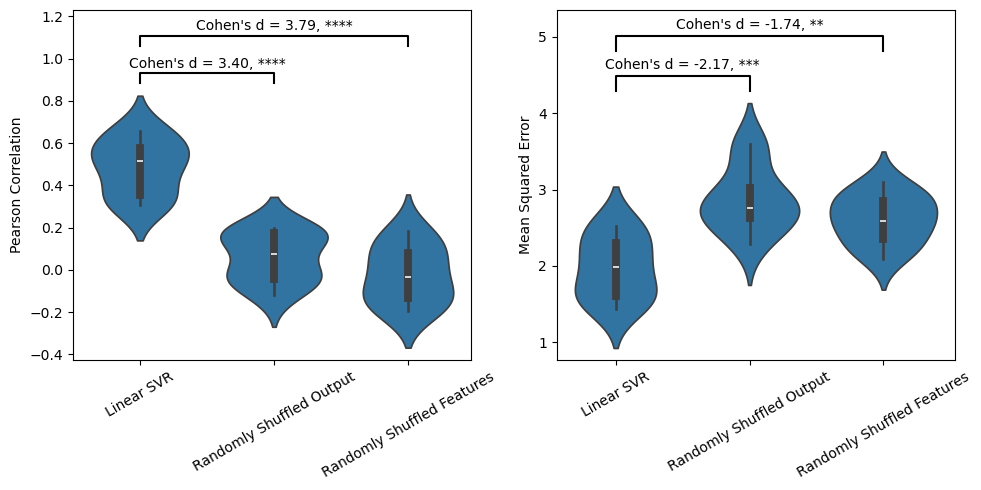

In [19]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,5))

for i, (metric, viz_df) in enumerate(viz_dfs.items()):
    viz_df = pd.melt(viz_df, value_name=metric, var_name = 'Model Type')
    
    # some formatting
    viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric]: 'Linear SVR', 
                              'random_y_test_' +mmap[metric]: 'Randomly Shuffled Output', 
                             'random_X_test_' +mmap[metric]: 'Randomly Shuffled Features'})
    
    # get statistics
    res_stats, mod_combs = get_stats(viz_df, random = True, metric_type = metric)
    
    sns.violinplot(data = viz_df, x = 'Model Type', y = metric, ax = ax[i])
    
    
    xlabels = [x._text for x in ax[i].get_xticklabels()]
    x_pos = dict(zip(xlabels, ax[i].get_xticks()))
    
    y_lower, y = ax[i].get_ylim()
    h = unit_map['h'][metric]
    
    
    ax[i].set_xticklabels(xlabels, 
                          rotation=30, 
                         ha = 'center')
    
    sig_counter = 0
    for j, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2
        
        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]
        
        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"
        
        if significance != 'N.S.':
#             y_pos = y+(sig_counter*0.15)
            y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric])
            ax[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                       [y_pos, y_pos+h, y_pos+h, y_pos], 
                       lw=1.5, c='black')
            y_pos*=unit_map['y_pos_scale'][metric]
            ax[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1
    if sig_counter != 0:
        ax[i].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric])
    ax[i].set_xlabel('')
    
    
fig.tight_layout()

We can see that the Linear SVR outperforms random baselines for both Pearson correlation and MSE. 

Let's also ensure the consensus non-linear SVRs did not perform better than the linear SVRs:

In [20]:
viz_df = best_res_df[[col for col in best_res_df if 'test' in col or col == 'fold']]
viz_df = viz_df[[col for col in viz_df if 'random' not in col]]
viz_df_corr = viz_df[[col for col in viz_df if 'corr' in col]]
viz_df_mse = viz_df[[col for col in viz_df if 'mse' in col]]
viz_dfs = {'Pearson Correlation': viz_df_corr, 
          'Mean Squared Error': viz_df_mse}
mmap = dict(zip(viz_dfs.keys(), ['corr', 'mse']))

unit_map = {'h': dict(zip(viz_dfs.keys(), [0.05, 0.2])),
            'y_pos_scale_0': dict(zip(viz_dfs.keys(), [0.175, 0.525])),
           'y_pos_scale': dict(zip(viz_dfs.keys(), [1.01, 1.01])), 
           'y_max_scale': dict(zip(viz_dfs.keys(), [1.15, 1.1]))}

/tmp/ipykernel_2843308/2872333834.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(xlabels,
/tmp/ipykernel_2843308/2872333834.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(xlabels,


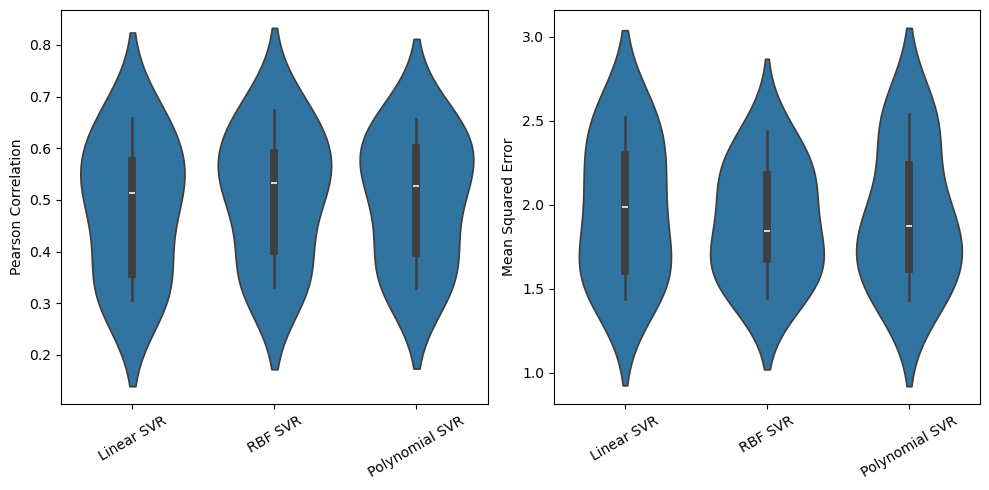

In [21]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,5))

for i, (metric, viz_df) in enumerate(viz_dfs.items()):
    viz_df = pd.melt(viz_df, value_name=metric, var_name = 'Model Type')
    
    # some formatting
    viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric]: 'Linear SVR', 
                              '_'.join(['test', mmap[metric], 'rbf']): 'RBF SVR', 
                             '_'.join(['test', mmap[metric], 'poly']): 'Polynomial SVR'})
    
    # get statistics
    res_stats, mod_combs = get_stats(viz_df, random = False, 
                                     metric_type = None # always two-sided
                                    )
    
    sns.violinplot(data = viz_df, x = 'Model Type', y = metric, ax = ax[i])
    
    
    xlabels = [x._text for x in ax[i].get_xticklabels()]
    x_pos = dict(zip(xlabels, ax[i].get_xticks()))
    
    y_lower, y = ax[i].get_ylim()
    h = unit_map['h'][metric]
    
    
    ax[i].set_xticklabels(xlabels, 
                          rotation=30, 
                         ha = 'center')
    
    sig_counter = 0
    for j, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2
        
        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]
        
        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"
        
        if significance != 'N.S.':
#             y_pos = y+(sig_counter*0.15)
            y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric])
            ax[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                       [y_pos, y_pos+h, y_pos+h, y_pos], 
                       lw=1.5, c='black')
            y_pos*=unit_map['y_pos_scale'][metric]
            ax[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1
    if sig_counter != 0:
        ax[i].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric])
    ax[i].set_xlabel('')
    
    
fig.tight_layout()

There are no significant differences between the consensus models for SVR with any of the tested kernels.